In [332]:
import sklearn as sk
import numpy as np
import pandas as pd
import time
from sklearn.cross_validation import KFold
from sklearn import tree
from sklearn import ensemble
from sklearn import datasets
import theano.tensor as th
from scipy import misc
import copy
from numpy.random import uniform
from numpy.random import normal
from sklearn.datasets import load_iris
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_classification
from math import copysign

import matplotlib.pylab as plt
%matplotlib inline

In [333]:
class autoencoder:
    def __init__(self, layers_list, learning_rate, alpha, activation_functions, cost_func, \
                 epochs_count, regularization, reg_param, batch_size, prob,\
                 reg_val_for_prob, sparse_num):
        
        self.layers_count = len(layers_list) -1
        self.weight_list = []
        self.learning_rate = learning_rate
        self.layers_list = layers_list
        self.alpha = alpha
        self.cost_func = cost_func
        self.activation_functions = activation_functions
        self.batch_size = batch_size
        self.epochs_count = epochs_count
        self.regularization = regularization
        self.reg_param = reg_param
        self.prob = prob
        self.reg_prob = reg_val_for_prob
        self.sparse_num = sparse_num
        for i in range(1, self.layers_count + 1):
            self.weight_list.append((normal(0, 0.1, (self.layers_list[i - 1] + 1, self.layers_list[i]))))
            
    def sigmoid(self, x):
        m = 1. / (1. + np.exp(-x * self.alpha))
        m = np.fmax(m, 0.001)
        m = np.fmin(m, 0.999)
        return m
    
    def der_sigmoid(self, x):
        return (1. - self.sigmoid(x)) * self.sigmoid(x) * self.alpha
    
    def square_cost_vec(self, y_true, y_pred):
        return 0.5 * ((y_true - y_pred) ** 2)
    
    def der_square_cost_vec(self, y_true, y_pred):
        return (y_pred - y_true)
    
    def predict(self, x):
        sparse_decode = None
        output = None
        neuron_out = x
        for num_layer in range(self.layers_count):
            neuron_out = np.dot(neuron_out, self.weight_list[num_layer])
            
            if (self.activation_functions[num_layer + 1] == 'sigmoid'):
                neuron_out = self.sigmoid(neuron_out)

            if (num_layer + 1 == self.sparse_num):
                sparse_decode = neuron_out
                
            if (num_layer == self.layers_count - 1):
                output = neuron_out
        
            neuron_out = np.insert(neuron_out, 0, -1, axis = 1)
            
        return sparse_decode, output
    
    def get_error(self, x):
        sparse, out = self.predict(x)
        y_err = np.sum((out - x[:, 1:]) ** 2) / (x.shape[0] * x.shape[1])
        return y_err
    
    def der_prob(self, aposteriori_prob):
        return (aposteriori_prob - self.prob) / ((1. - aposteriori_prob) * aposteriori_prob)
    
    def fit(self, x):
        batch_count = x.shape[0] // self.batch_size

        x = np.insert(x, 0, -1, axis = 1)
        shuffle(x)
        x_test = x[0.95 * x.shape[0]:]
        x = x[:0.95 * x.shape[0]]
        
        for num_epoch in range(self.epochs_count):
            print "Epoch num is: ", num_epoch
            print "err is:", self.get_error(x_test)
            shuffle(x)
            for batch_num in range(batch_count):
                data = x[batch_num * self.batch_size:(batch_num + 1) * self.batch_size]
                neuron_out = [data]
                neuron_sum = [data[:, 1:]]
                w_u = []
                for num_layer in range(self.layers_count):
                    s = np.dot(neuron_out[-1], self.weight_list[num_layer])
                    neuron_sum.append(s)
                    if (self.activation_functions[num_layer + 1] == 'sigmoid'):
                        s = self.sigmoid(s)
                    if (num_layer != self.layers_count - 1):
                        s = np.insert(s, 0, -1, axis = 1)
                    neuron_out.append(s)

                if (self.cost_func == 'square'):
                    der_neuron = self.der_square_cost_vec(data[:, 1:], neuron_out[-1])

                for layer_num in range(self.layers_count - 1, -1, -1):
                    w_u.insert(0, np.sum( map(lambda x, y: np.dot(x.reshape(-1, 1), y.reshape(1, -1)), neuron_out[layer_num], der_neuron), axis = 0))
                    if self.activation_functions[layer_num] == 'sigmoid':
                        der_neuron = np.dot(der_neuron, self.weight_list[layer_num].T)[:, 1:] * self.der_sigmoid(neuron_sum[layer_num])
                    
                self.weight_list = map(lambda x, y: x - y * (self.learning_rate / self.batch_size), self.weight_list, w_u)
            

In [334]:
im = misc.imread('data/big_alphabet_29x29/mutant-0-0-0.bmp', flatten='grey')
alphabet_size = 26
im_size = 29

In [335]:
x = []
y = []
x_test = []
y_test = []
for letter in range(alphabet_size):
    for i in range(9):
        path = "data/big_alphabet_29x29/mutant-" + str(letter) + "-" + str(i) + "-0.bmp"
        im = misc.imread(path, flatten='grey')
        x.append(im.reshape(im_size * im_size))
        x[-1] /= 255.0

for letter in range(alphabet_size):
    path = "data/big_alphabet_29x29/class-" + str(letter) + ".bmp"
    im = misc.imread(path, flatten='grey')
    x_test.append(im.reshape(im_size * im_size))
    x_test[-1] /= 255.

    
x = np.asarray(x)
y = x.copy()
x_test = np.asarray(x_test)
y_test = x_test.copy()

In [336]:
print x.shape, y.shape

(234, 841) (234, 841)


In [337]:
autoencoder = autoencoder(layers_list = [841, 500, 500, 32, 500, 500, 841], learning_rate = 0.001, alpha = 1.0,\
                          activation_functions = ['x', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'x'],\
                         cost_func = 'square', epochs_count = 15, regularization = 'l2', reg_param = 0.1, batch_size = 25,\
                         prob = 0.05, reg_val_for_prob = 0.5, sparse_num = 3)
autoencoder.fit(x)

decode, real = autoencoder.predict(np.insert(x_test, 0, -1, axis = 1))
print np.mean((x_test - real) ** 2)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:69: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:70: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Epoch num is:  0
err is: 2.40055064785
Epoch num is:  1
err is: 0.170338735409
Epoch num is:  2
err is: 0.0660123583979
Epoch num is:  3
err is: 0.0588181789975
Epoch num is:  4
err is: 0.0581840080675
Epoch num is:  5
err is: 0.0580982126751
Epoch num is:  6
err is: 0.058081999195
Epoch num is:  7
err is: 0.0580783956041
Epoch num is:  8
err is: 0.0580775009544
Epoch num is:  9
err is: 0.0580772258068
Epoch num is:  10
err is: 0.0580770959271
Epoch num is:  11
err is: 0.0580770005942
Epoch num is:  12
err is: 0.0580769135647
Epoch num is:  13
err is: 0.0580768285464
Epoch num is:  14
err is: 0.0580767440133
0.0599964873362


50.4570458497
(29, 29)


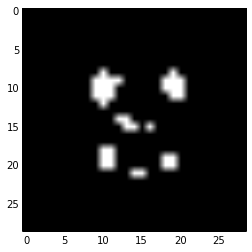

(29, 29)


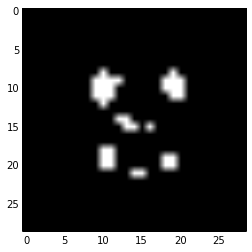

(29, 29)


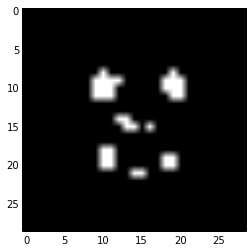

(29, 29)


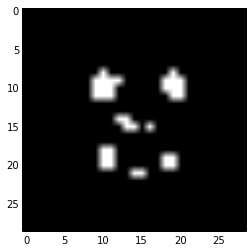

(29, 29)


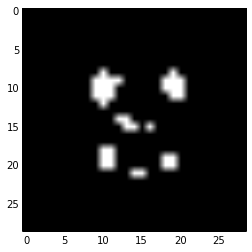

(29, 29)


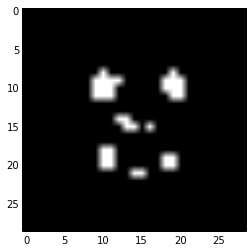

(29, 29)


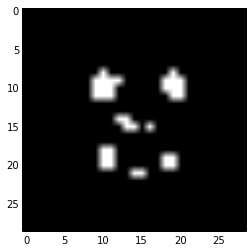

(29, 29)


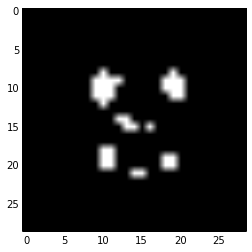

(29, 29)


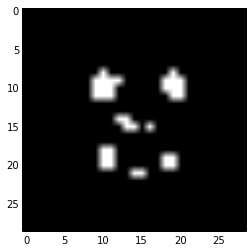

(29, 29)


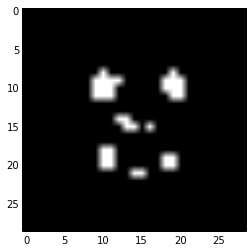

(29, 29)


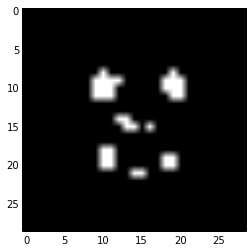

(29, 29)


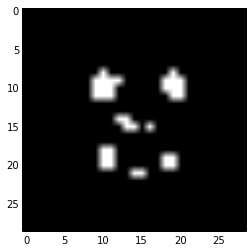

(29, 29)


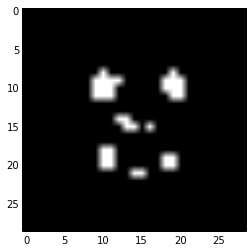

(29, 29)


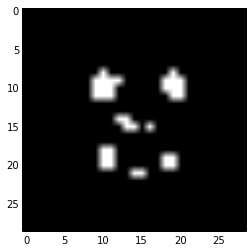

(29, 29)


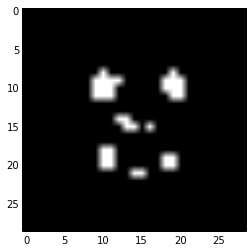

(29, 29)


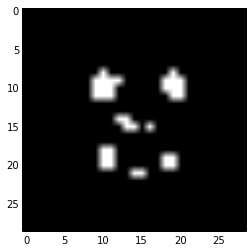

(29, 29)


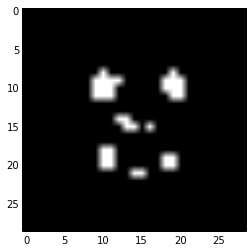

(29, 29)


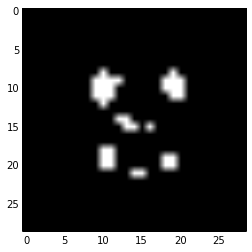

(29, 29)


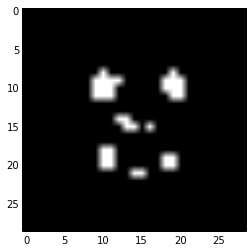

(29, 29)


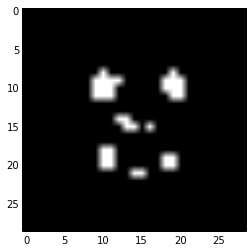

(29, 29)


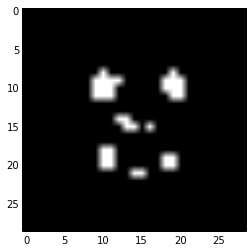

(29, 29)


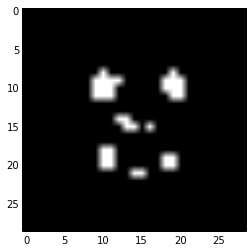

(29, 29)


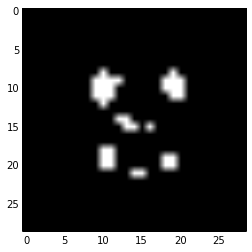

(29, 29)


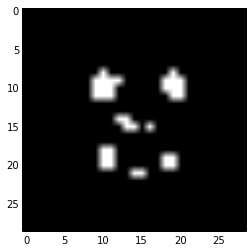

(29, 29)


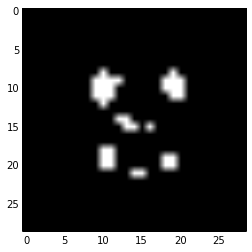

(29, 29)


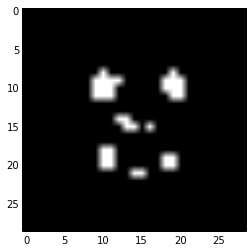

In [338]:
print np.sum((real - y_test)**2) / len(real)
im_size = 29
for j in range(real.shape[0]):
    f = real[j].copy()
    f = f.reshape((im_size, im_size))
    print f.shape
    for i in range(29):
        for j in range(29):
            if (f[i][j] >= 0.5):
                f[i][j] = 255.
            else:
                f[i][j] = 0.
    plt.imshow(f, cmap = 'Greys')
    plt.show()

In [5]:
data = pd.read_csv('mnist.csv', sep = ',')
data = np.asarray(data)
print data.shape

(42000, 785)


In [96]:
autoencoder = autoencoder(layers_list = [785, 70, 785], learning_rate = 0.01, alpha = 1, activation_functions = ['simoid', 'x'],\
                         cost_func = 'square', epochs_count = 500, regularization = 'l2', reg_param = 0.1, batch_size = 20,\
                         prob = 0.05, reg_val_for_prob = 0.5, sparse_num = 0)
autoencoder.fit(data)
decode, real = autoencder.predict(data)
print np.mean((data - real) ** 2)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:50: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:51: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Epoch num is:  0


ValueError: 'axis' entry is out of bounds